In [1]:
import tensorflow_probability as tfp
import numpy as np
import tensorflow as tf

import time
from tqdm import tqdm
import pickle

from math import *

import matplotlib.dates as mdates
import matplotlib.ticker as ticker

myFmt = mdates.DateFormatter('%Hh')

import pandas as pd
np.set_printoptions(suppress=True,precision=6)
import matplotlib.pyplot as plt
import matplotlib

plt.style.use('ggplot') 
plt.style.use('seaborn-paper') 
plt.style.use('seaborn-whitegrid')

import sys

from tensorflow_probability import distributions as tfd
from geopy.distance import geodesic

%matplotlib inline

from move_ns import moveNS

In [10]:
df = pd.read_csv('data/shift.csv',index_col=0)
X = df[['Latitude','Longitude']].values
L = df['Lengthscale'].values
meanX = df['MeanX'].values
meanY = df['MeanY'].values

mean_x = np.mean(X,axis=0)
X = X - mean_x

secs =(pd.to_datetime(df['Date'])- pd.datetime(2000,1,1)).dt.seconds.astype(float).values
days = (pd.to_datetime(df['Date'])- pd.datetime(2000,1,1)).dt.days.astype(float).values

T = (days*24*60+secs/60)/(60*24) 
T = T-T[0]
T=T[:,None]



z_skip=10
Z = T[::z_skip].copy()

<ipython-input-10-242853887f64>:10: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  secs =(pd.to_datetime(df['Date'])- pd.datetime(2000,1,1)).dt.seconds.astype(float).values
<ipython-input-10-242853887f64>:11: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  days = (pd.to_datetime(df['Date'])- pd.datetime(2000,1,1)).dt.days.astype(float).values


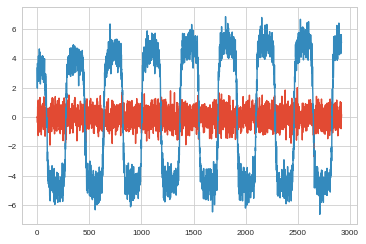

In [11]:
plt.plot(X)

In [12]:
def sp(x):
        # softplus transform with shift 
        return tf.nn.softplus(x)+1e-4

def local_periodic_kernel(x1):
    # locally periodic kernel with single variable parameter. Other parameters are set 
    # to encode annual activity pattern (period=365), RBF kernel is set to allow for 
    # slow varying mean locations (2-year lengthscale).

    k1 = tfp.math.psd_kernels.ExpSinSquared(x1,np.float64(0.85),np.float64(365.0))
    #k1 = tfp.math.psd_kernels.ExpSinSquared(x1,X2,np.float64(365.0))
    
    k2 = tfp.math.psd_kernels.ExponentiatedQuadratic(np.float64(1.0),np.float64(5*365.0))
    #k1 = tfp.math.psd_kernels.ExpSinSquared(x1,np.float64(0.5),np.float64(365.0))
    #k2 = tfp.math.psd_kernels.ExponentiatedQuadratic(np.float64(1.0),x2*np.float64(365.0))
    #k2 = tfp.math.psd_kernels.ExponentiatedQuadratic(x2,np.float64(2*365.0))
    return k1*k2


# initial value of kernel parameters
mparams_init=[2.0] 
#mparams_init=[5.0,4.0] 
lparams_init=[2.0]
aparams_init=[-1.0]

# prior distribution on parameters - changed to 20 
lpriors = [tfd.Normal(loc = np.float64(2.),scale=np.float64(100))]
apriors = [tfd.Normal(loc = np.float64(-1.),scale=np.float64(100))]

# transform for parameter to ensure positive
mtransforms=[sp] 

# prior distribution on parameter 
mpriors = [tfd.Normal(loc=np.float64(2.), scale=np.float64(1))]#,
          #tfd.Normal(loc=np.float64(0), scale=np.float64(1))]#, tfd.Normal(loc=np.float64(0.), scale=np.float64(0.1))]

# create the model 
mover = moveNS(T,X,Z, BATCH_SIZE=1000, MIN_REMAIN=920,
                       mkernel=local_periodic_kernel, 
                       mparams_init=mparams_init, 
                       mpriors=mpriors, 
                       mtransforms=mtransforms,
                       aparams_init=aparams_init, 
                       apriors=apriors, 
                       lparams_init=lparams_init, 
                       lpriors=lpriors, mean_obs_noise=0, std_obs_noise=5.0 )

In [13]:
mover.kernel_params

[<tf.Variable 'obs_noise_variance:0' shape=() dtype=float64, numpy=0.0>,
 <tf.Variable 'ls_mean:0' shape=() dtype=float64, numpy=2.0>,
 <tf.Variable 'amp_mean:0' shape=() dtype=float64, numpy=-1.0>,
 <tf.Variable 'v_mean_latents:0' shape=(292, 2) dtype=float64, numpy=
 array([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0.

In [14]:

learning_rate = tf.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-1,
    decay_steps=50,
    decay_rate=0.99,
    staircase=True)


optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate,beta_2=0.99)
train_steps = 1000
pbar = tqdm(range(train_steps))
loss_history = np.zeros((train_steps))
for i in pbar:
    with tf.GradientTape() as t:
        loss = -mover.log_posterior(*mover.kernel_params)
    loss_history[i] = loss.numpy()
    pbar.set_description("Loss %f" % (loss_history[i]))

    gradients = t.gradient(loss, mover.kernel_params)
    optimizer.apply_gradients(zip(gradients, mover.kernel_params))
#n=3.5

Loss 2794.366920: 100%|██████████| 1000/1000 [01:40<00:00,  9.99it/s]


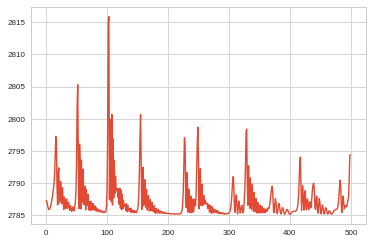

In [15]:
plt.plot(loss_history[500:])

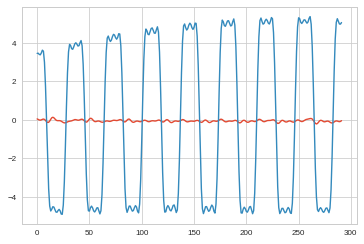

In [16]:
Zin = np.linspace(0,365*8,num=500,endpoint=False).astype(np.float64)[:,None]
aa = mover.get_mean()
plt.plot(aa)

In [17]:
mover.kernel_params

[<tf.Variable 'obs_noise_variance:0' shape=() dtype=float64, numpy=-1.0071376557520373>,
 <tf.Variable 'ls_mean:0' shape=() dtype=float64, numpy=1.9776956180101621>,
 <tf.Variable 'amp_mean:0' shape=() dtype=float64, numpy=-1.2673816338427994>,
 <tf.Variable 'v_mean_latents:0' shape=(292, 2) dtype=float64, numpy=
 array([[ 0.02454 ,  1.665918],
        [-0.060579,  0.19276 ],
        [-0.013175,  0.482634],
        [ 0.273972,  1.94334 ],
        [-0.175702,  0.629447],
        [-0.261234, -3.859747],
        [-0.114494, -4.139391],
        [ 0.044157, -2.13778 ],
        [ 0.142132,  0.277943],
        [ 0.243178,  1.787798],
        [ 0.233914,  1.31791 ],
        [ 0.024287, -0.704879],
        [-0.244003, -2.346124],
        [-0.302005, -2.163956],
        [-0.095073, -0.828991],
        [ 0.154868,  0.152055],
        [ 0.21811 ,  0.297456],
        [ 0.078325, -0.084865],
        [-0.092629, -0.816666],
        [-0.139559, -1.746044],
        [-0.074651, -2.280126],
        [-0.0

In [ ]:
samples = mover.mala_sample(num_samples=100, skip=10, burn_in=500)

AR 0.525090 SS 0.022929:  74%|███████▍  | 1116/1500 [08:08<02:48,  2.28it/s]

In [ ]:
means =(mover.get_mean_samples())
#amps = (mover.get_amplitude_samples(X=Zin))

In [ ]:
means.shape

In [ ]:
plt.figure(figsize=(10,6))
Z_time=np.array([np.datetime64('2019') + np.timedelta64(int(k*60*60), 's') for k in Zin])

for i in range(0,means.shape[0]):
    plt.plot(Z_time[np.argsort(Z_time)],means[i,:,0],c='C3',alpha=0.02,linewidth=1.0)
#plt.figure(figsize=(10,6))
Z_time=np.array([np.datetime64('2019') + np.timedelta64(int(k*60*60), 's') for k in Zin])

for i in range(0,means.shape[0]):
    plt.plot(Z_time[np.argsort(Z_time)],means[i,:,1],c='C1',alpha=0.02,linewidth=1.0)

In [ ]:
gridsize = (2, 1)
fig = plt.figure(figsize=(4, 6))
ax1 = plt.subplot2grid(gridsize, (0, 0))
ax2 = plt.subplot2grid(gridsize, (1, 0))

s1 = 100//z_skip
s2 = 465//z_skip
Z_time=np.array([np.datetime64('2019') + np.timedelta64(int(k), 'D') for k in Z])
Z_time2=np.array([np.datetime64('2019') + np.timedelta64(int(k-365*6), 'D') for k in Z])


for i in range(0,means.shape[0]):
    ax1.plot(Z_time[s1:s2]+180,means[i,s1:s2,1],c='C1', alpha=0.002,linewidth=0.5)

s1 = s1+365*6//z_skip
s2 = s2+365*6//z_skip    

for i in range(0,means.shape[0]):
    ax1.plot(Z_time2[s1:s2]+180,means[i,s1:s2,1],c='C0', alpha=0.002,linewidth=0.5)


#plt.xlim(0,1)
ax1.set_xlabel('month')
ax1.set_ylabel('y-location')




ax1.xaxis.set_major_formatter(myFmt)


meanmean = np.zeros(8)
meanperc1=  np.zeros(8)
meanperc2=  np.zeros(8)

for i in range(8):
    ii = 2+round(i*365/4)
    meanmean[i] = np.mean(means[:,ii,1])
    meanperc1[i] = np.percentile(means[:,ii,1], 2.5, axis=0)
    meanperc2[i] = np.percentile(means[:,ii,1], 97.5, axis=0)
    
ax2.plot(np.arange(1,9), meanmean,c='C0', lw=1)

ax2.fill_between(np.arange(1,9), meanperc1,
                 meanperc2,
                 color='C0', alpha = 0.3)


for i in range(8):
    ii = 2+45+round(i*365/4)
    meanmean[i] = np.mean(means[:,ii,1])
    meanperc1[i] = np.percentile(means[:,ii,1], 2.5, axis=0)
    meanperc2[i] = np.percentile(means[:,ii,1], 97.5, axis=0)
    
ax2.plot(np.arange(1,9), meanmean,c='C1', lw=1)

ax2.fill_between(np.arange(1,9), meanperc1,
                 meanperc2,
                 color='C1', alpha = 0.3)

ax2.set_ylim(-1,11)


ax2.set_xlabel('year')
ax2.set_ylabel('y-location')


plt.tight_layout(h_pad=2,w_pad=3)



xp = ax1.get_position().x0
yp = ax1.get_position().y1    
fig.text(xp - .09, yp- .01, 'A', size=12)

xp = ax2.get_position().x0
yp = ax2.get_position().y1    
fig.text(xp - .09, yp- .01, 'B', size=12)

plt.savefig('figures/shift_combined.png', dpi=300, bbox_inches = "tight")
